Experiment E1-11:
- binary classification
- dataset train 3500, val 1500
- BATCH_SIZE = 20
- IMAGE_SIZE = 384
- EPOCHS = 30
- criterion = nn.BCEWithLogitsLoss()
- optimizer = Adam
- lr=1e-5
- augmentation

model:
- self.base_model(x), mobilenet_v3_small
- unfreeze 3 layers
- self.globalavg(x) # (2,2)
- self.flatten(x)
- self.fc(x) # (2304,512)->Dropout(0.5)->Relu->(512,1)

In [1]:
import numpy as np
import os
import sys
import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms, models
import torchvision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from PIL import Image

In [2]:
# load common py
sys.path.append('../src')
import config
import common_utils
import data_utils
import train_utils
import plot_utils


In [3]:
# override config for experiment
EXP_CODE = "E1-11"
SAVE_FILENAME = f"stage1-{EXP_CODE}-metrics"

config.EPOCHS = 30
config.LEARNING_RATE = 1e-5
config.IMAGE_SIZE = 384

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

common_utils.set_seed(config.SEED)


In [5]:
df = pd.read_csv(config.TRAIN_CSV)

In [6]:
# split data into train, val, test 70/15/15
# for fast training, use only 3500 and 1500 samples for train and val

train_df, val_df, test_df, train_small_df, val_small_df = data_utils.split_data(df, config.SEED, small_train_size=3500, small_val_size=1500)

In [7]:
# create transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),   
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [8]:
# create datasets
train_small_dataset = data_utils.SteelDataset(df=train_small_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=train_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                    )
val_small_dataset = data_utils.SteelDataset(df=val_small_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=test_val_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                   )


In [9]:
train_small_loader = DataLoader(train_small_dataset, batch_size=config.BATCH_SIZE,
                          shuffle=True,
                          num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                          )

val_small_loader = DataLoader(val_small_dataset, batch_size=config.BATCH_SIZE,
                         shuffle=False,
                         num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                         )


In [10]:
# create model
class SteelModel(nn.Module):
    def __init__(self):
        super(SteelModel, self).__init__()

        self.base_model = models.mobilenet_v3_small(weights='IMAGENET1K_V1').features
        for param in self.base_model.parameters():
            param.requires_grad = False

        for p in self.base_model[-3:].parameters():
            p.requires_grad = True

        # Remove original classifier
        #self.base_model.classifier = nn.Identity()

        self.globalavg = nn.AdaptiveAvgPool2d((2, 2))

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(2304, 512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512, 1),
        )
               

    def forward(self, x):
        x = self.base_model(x)
        #print(x.shape)
        x = self.globalavg(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.fc(x)
        #print(x.shape)
        return x 

In [11]:
model = SteelModel()
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

In [12]:
%%time

arr_train_acc = []
arr_train_loss = []
arr_train_precision = []
arr_train_recall = []
arr_train_f1 = []
arr_train_rocauc = []
arr_train_conf_matrix = []

arr_val_acc = []
arr_val_loss = []
arr_val_precision = []
arr_val_recall = []
arr_val_f1 = []
arr_val_rocauc = []
arr_val_conf_matrix = []

idx = 0
for epoch in range(config.EPOCHS):
    train_loss, train_all_labels, train_all_preds, train_all_probs = train_utils.train_one_epoch(model, train_small_loader, criterion, optimizer, device)
    val_loss, val_all_labels, val_all_preds, val_all_probs = train_utils.validate_one_epoch(model, val_small_loader, criterion, device)

    # train metrics
    train_accuracy = (train_all_preds == train_all_labels).mean()
    train_precision = precision_score(train_all_labels, train_all_preds)
    train_recall = recall_score(train_all_labels, train_all_preds)
    train_f1 = f1_score(train_all_labels, train_all_preds)
    train_rocauc = roc_auc_score(train_all_labels, train_all_probs)
    train_conf_matrix = confusion_matrix(train_all_labels, train_all_preds)
    train_tn, train_fp, train_fn, train_tp = train_conf_matrix.ravel()
    
    arr_train_loss.append(train_loss)
    arr_train_acc.append(train_accuracy)
    arr_train_precision.append(train_precision)
    arr_train_recall.append(train_recall)
    arr_train_f1.append(train_f1)
    arr_train_rocauc.append(train_rocauc)
    arr_train_conf_matrix.append({'tn': train_tn, 'fp': train_fp, 'fn': train_fn, 'tp': train_tp})

    # val metrics
    val_accuracy = (val_all_preds == val_all_labels).mean()
    val_precision = precision_score(val_all_labels, val_all_preds)
    val_recall = recall_score(val_all_labels, val_all_preds)
    val_f1 = f1_score(val_all_labels, val_all_preds)
    val_rocauc = roc_auc_score(val_all_labels, val_all_probs)
    val_conf_matrix = confusion_matrix(val_all_labels, val_all_preds)
    val_tn, val_fp, val_fn, val_tp = val_conf_matrix.ravel()

    arr_val_loss.append(val_loss)
    arr_val_acc.append(val_accuracy)
    arr_val_precision.append(val_precision)
    arr_val_recall.append(val_recall)
    arr_val_f1.append(val_f1)
    arr_val_rocauc.append(val_rocauc)
    arr_val_conf_matrix.append({'tn': val_tn, 'fp': val_fp, 'fn': val_fn, 'tp': val_tp})

    print(idx+1)
    print(f"Epoch {epoch+1}/{config.EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
    print(f"  Val Loss  : {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
    print(f"  Train Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1: {train_f1:.4f} | ROC AUC: {train_rocauc:.4f}")
    print(f"  Train Confusion Matrix: TN={train_tn}, FP={train_fp}, FN={train_fn}, TP={train_tp}")
    print(f"  Val Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f} | ROC AUC: {val_rocauc:.4f}")
    print(f"  Val Confusion Matrix: TN={val_tn}, FP={val_fp}, FN={val_fn}, TP={val_tp}")

    idx += 1
    #break


1
Epoch 1/30
  Train Loss: 0.6477 | Train Acc: 0.6403
  Val Loss  : 0.6104 | Val Acc: 0.7300
  Train Precision: 0.6332 | Recall: 0.8111 | F1: 0.7112 | ROC AUC: 0.7034
  Train Confusion Matrix: TN=691, FP=898, FN=361, TP=1550
  Val Precision: 0.6872 | Recall: 0.9280 | F1: 0.7896 | ROC AUC: 0.8449
  Val Confusion Matrix: TN=335, FP=346, FN=59, TP=760
2
Epoch 2/30
  Train Loss: 0.5637 | Train Acc: 0.7369
  Val Loss  : 0.5124 | Val Acc: 0.7753
  Train Precision: 0.7061 | Recall: 0.8875 | F1: 0.7865 | ROC AUC: 0.8256
  Train Confusion Matrix: TN=883, FP=706, FN=215, TP=1696
  Val Precision: 0.7363 | Recall: 0.9170 | F1: 0.8167 | ROC AUC: 0.8900
  Val Confusion Matrix: TN=412, FP=269, FN=68, TP=751
3
Epoch 3/30
  Train Loss: 0.4903 | Train Acc: 0.7740
  Val Loss  : 0.4378 | Val Acc: 0.8127
  Train Precision: 0.7539 | Recall: 0.8702 | F1: 0.8079 | ROC AUC: 0.8623
  Train Confusion Matrix: TN=1046, FP=543, FN=248, TP=1663
  Val Precision: 0.7976 | Recall: 0.8803 | F1: 0.8369 | ROC AUC: 0.9072


In [13]:
df_metrics = train_utils.build_metric_df(
    arr_train_loss, arr_train_acc, arr_train_precision, arr_train_recall, 
    arr_train_f1, arr_train_rocauc, arr_train_conf_matrix,
    arr_val_loss, arr_val_acc, arr_val_precision, arr_val_recall, 
    arr_val_f1, arr_val_rocauc, arr_val_conf_matrix
)


In [14]:
df_metrics

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,train_conf_matrix,val_loss,val_acc,val_precision,...,val_rocauc,val_conf_matrix,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
0,0.647740,0.640286,0.633170,0.811094,0.711172,0.703402,"{'tn': 691, 'fp': 898, 'fn': 361, 'tp': 1550}",0.610395,0.730000,0.687161,...,0.844865,"{'tn': 335, 'fp': 346, 'fn': 59, 'tp': 760}",691,898,361,1550,335,346,59,760
1,0.563730,0.736857,0.706078,0.887493,0.786460,0.825647,"{'tn': 883, 'fp': 706, 'fn': 215, 'tp': 1696}",0.512403,0.775333,0.736275,...,0.890045,"{'tn': 412, 'fp': 269, 'fn': 68, 'tp': 751}",883,706,215,1696,412,269,68,751
2,0.490282,0.774000,0.753853,0.870225,0.807870,0.862325,"{'tn': 1046, 'fp': 543, 'fn': 248, 'tp': 1663}",0.437827,0.812667,0.797566,...,0.907234,"{'tn': 498, 'fp': 183, 'fn': 98, 'tp': 721}",1046,543,248,1663,498,183,98,721
3,0.435922,0.798000,0.789981,0.858189,0.822674,0.887058,"{'tn': 1153, 'fp': 436, 'fn': 271, 'tp': 1640}",0.386568,0.838667,0.831991,...,0.924615,"{'tn': 535, 'fp': 146, 'fn': 96, 'tp': 723}",1153,436,271,1640,535,146,96,723
4,0.404421,0.820571,0.811559,0.874411,0.841814,0.901533,"{'tn': 1201, 'fp': 388, 'fn': 240, 'tp': 1671}",0.352742,0.861333,0.874847,...,0.936061,"{'tn': 579, 'fp': 102, 'fn': 106, 'tp': 713}",1201,388,240,1671,579,102,106,713
5,0.380647,0.819143,0.816964,0.861852,0.838808,0.910756,"{'tn': 1220, 'fp': 369, 'fn': 264, 'tp': 1647}",0.323128,0.865333,0.855825,...,0.943321,"{'tn': 556, 'fp': 125, 'fn': 77, 'tp': 742}",1220,369,264,1647,556,125,77,742
6,0.362945,0.837714,0.836591,0.873365,0.854583,0.919313,"{'tn': 1263, 'fp': 326, 'fn': 242, 'tp': 1669}",0.309797,0.872667,0.873810,...,0.946183,"{'tn': 575, 'fp': 106, 'fn': 85, 'tp': 734}",1263,326,242,1669,575,106,85,734
7,0.342688,0.841429,0.838661,0.878598,0.858165,0.927419,"{'tn': 1266, 'fp': 323, 'fn': 232, 'tp': 1679}",0.298397,0.869333,0.876663,...,0.949493,"{'tn': 579, 'fp': 102, 'fn': 94, 'tp': 725}",1266,323,232,1679,579,102,94,725
8,0.329383,0.850857,0.848120,0.885400,0.866359,0.932915,"{'tn': 1286, 'fp': 303, 'fn': 219, 'tp': 1692}",0.292887,0.871333,0.893216,...,0.951138,"{'tn': 596, 'fp': 85, 'fn': 108, 'tp': 711}",1286,303,219,1692,596,85,108,711
9,0.329831,0.855429,0.857143,0.882261,0.869520,0.932111,"{'tn': 1308, 'fp': 281, 'fn': 225, 'tp': 1686}",0.280155,0.880000,0.880810,...,0.954547,"{'tn': 581, 'fp': 100, 'fn': 80, 'tp': 739}",1308,281,225,1686,581,100,80,739


In [15]:
print('Val Metrics:')
print(df_metrics[config.VAL_METRICS])
print('')
print('Val Confusion Matrix:')
print(df_metrics[config.VAL_CF])

Val Metrics:
    val_loss   val_acc  val_precision  val_recall    val_f1  val_rocauc
0   0.610395  0.730000       0.687161    0.927961  0.789610    0.844865
1   0.512403  0.775333       0.736275    0.916972  0.816748    0.890045
2   0.437827  0.812667       0.797566    0.880342  0.836912    0.907234
3   0.386568  0.838667       0.831991    0.882784  0.856635    0.924615
4   0.352742  0.861333       0.874847    0.870574  0.872705    0.936061
5   0.323128  0.865333       0.855825    0.905983  0.880190    0.943321
6   0.309797  0.872667       0.873810    0.896215  0.884870    0.946183
7   0.298397  0.869333       0.876663    0.885226  0.880923    0.949493
8   0.292887  0.871333       0.893216    0.868132  0.880495    0.951138
9   0.280155  0.880000       0.880810    0.902320  0.891435    0.954547
10  0.274672  0.879333       0.875294    0.908425  0.891552    0.955999
11  0.267595  0.886667       0.894289    0.898657  0.896468    0.957982
12  0.258698  0.886000       0.879391    0.916972  

In [16]:
df_metrics.describe()

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,val_loss,val_acc,val_precision,val_recall,val_f1,val_rocauc,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.0000,30.0000,30.000000,30.000000,30.000000,30.000000
mean,0.316931,0.857143,0.855397,0.894087,0.873663,0.931897,0.282024,0.880911,0.885112,0.904029,0.893447,0.953318,1291.400000,297.600000,202.4000,1708.6000,580.966667,100.033333,78.600000,740.400000
std,0.103048,0.057929,0.063478,0.024206,0.044945,0.054797,0.094831,0.042609,0.056406,0.015553,0.031982,0.028685,162.786215,162.786215,46.2576,46.2576,63.938809,63.938809,12.737672,12.737672
min,0.223968,0.640286,0.633170,0.811094,0.711172,0.703402,0.205430,0.730000,0.687161,0.868132,0.789610,0.844865,691.000000,170.000000,149.0000,1550.0000,335.000000,53.000000,54.000000,711.000000
25%,0.244892,0.843786,0.841026,0.880691,0.860214,0.928592,0.222210,0.871667,0.875636,0.897741,0.881910,0.949904,1271.000000,204.500000,170.2500,1683.0000,578.250000,66.000000,70.250000,735.250000
50%,0.283895,0.877714,0.877593,0.902407,0.889620,0.950504,0.249622,0.897000,0.908703,0.904762,0.905242,0.963625,1349.500000,239.500000,186.5000,1724.5000,606.500000,74.500000,78.000000,741.000000
75%,0.339474,0.894214,0.895189,0.910911,0.904024,0.963382,0.297020,0.905833,0.918026,0.914225,0.913315,0.970557,1384.500000,318.000000,228.0000,1740.7500,615.000000,102.750000,83.750000,748.750000
max,0.647740,0.905143,0.911041,0.922030,0.913900,0.969431,0.610395,0.917333,0.932911,0.934066,0.923645,0.974682,1419.000000,898.000000,361.0000,1762.0000,628.000000,346.000000,108.000000,765.000000


In [17]:
print(df_metrics.describe())

       train_loss  train_acc  train_precision  train_recall   train_f1  \
count   30.000000  30.000000        30.000000     30.000000  30.000000   
mean     0.316931   0.857143         0.855397      0.894087   0.873663   
std      0.103048   0.057929         0.063478      0.024206   0.044945   
min      0.223968   0.640286         0.633170      0.811094   0.711172   
25%      0.244892   0.843786         0.841026      0.880691   0.860214   
50%      0.283895   0.877714         0.877593      0.902407   0.889620   
75%      0.339474   0.894214         0.895189      0.910911   0.904024   
max      0.647740   0.905143         0.911041      0.922030   0.913900   

       train_rocauc   val_loss    val_acc  val_precision  val_recall  \
count     30.000000  30.000000  30.000000      30.000000   30.000000   
mean       0.931897   0.282024   0.880911       0.885112    0.904029   
std        0.054797   0.094831   0.042609       0.056406    0.015553   
min        0.703402   0.205430   0.730000    

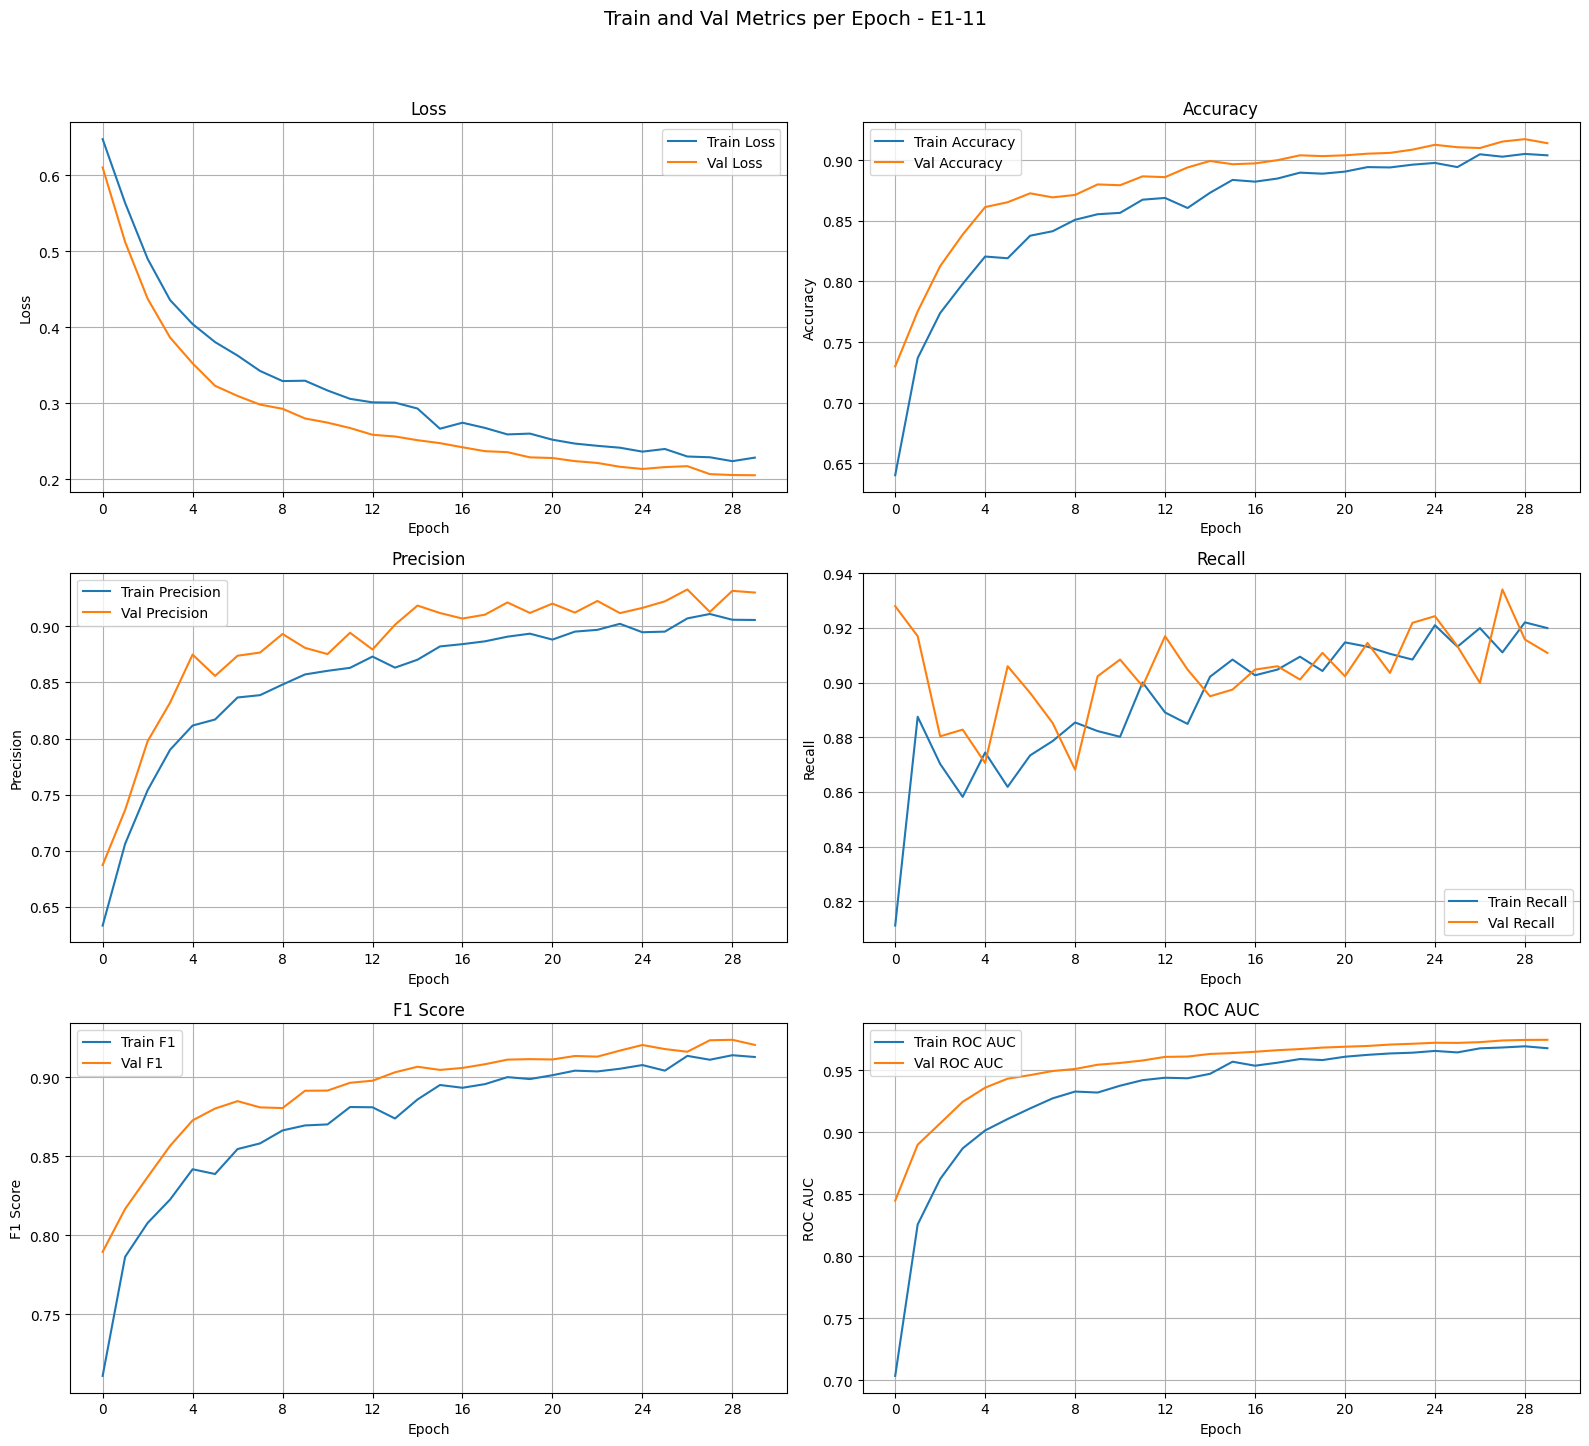

In [18]:
plot_utils.plot_train_val_metrics(df_metrics, exp_code=EXP_CODE, save_path=SAVE_FILENAME+".png")

In [19]:
df_train_conf_matrix = df_metrics['train_conf_matrix'].apply(lambda x: pd.Series([x['tn'], x['fp'], x['fn'], x['tp']]))
df_val_conf_matrix = df_metrics['val_conf_matrix'].apply(lambda x: pd.Series([x['tn'], x['fp'], x['fn'], x['tp']]))
#df_metrics[['val_tn', 'val_fp', 'val_fn', 'val_tp']]
df_train_conf_matrix.columns = ['train_tn', 'train_fp', 'train_fn', 'train_tp']
df_val_conf_matrix.columns = ['val_tn', 'val_fp', 'val_fn', 'val_tp']



In [20]:
df_train_conf_matrix.describe()

,train_tn,train_fp,train_fn,train_tp
count,30.000000,30.000000,30.0000,30.0000
mean,1291.400000,297.600000,202.4000,1708.6000
std,162.786215,162.786215,46.2576,46.2576
min,691.000000,170.000000,149.0000,1550.0000
25%,1271.000000,204.500000,170.2500,1683.0000
50%,1349.500000,239.500000,186.5000,1724.5000
75%,1384.500000,318.000000,228.0000,1740.7500
max,1419.000000,898.000000,361.0000,1762.0000


In [21]:
df_val_conf_matrix.describe()

,val_tn,val_fp,val_fn,val_tp
count,30.000000,30.000000,30.000000,30.000000
mean,580.966667,100.033333,78.600000,740.400000
std,63.938809,63.938809,12.737672,12.737672
min,335.000000,53.000000,54.000000,711.000000
25%,578.250000,66.000000,70.250000,735.250000
50%,606.500000,74.500000,78.000000,741.000000
75%,615.000000,102.750000,83.750000,748.750000
max,628.000000,346.000000,108.000000,765.000000


In [22]:
df_metrics.to_csv(SAVE_FILENAME+".csv", index=False)